In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy as scp
import scipy.special

import sympy as sy

import torch
from torch.nn import functional as F
from torch import nn, Tensor

import matplotlib.pyplot as plt
import seaborn as sns

from grassmann_distribution.utils import check_valid_sigma
from grassmann_distribution.GrassmannDistribution import GrassmannBinary



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Sympy calculations

In [9]:

a,b,c,d,e,f,g,h,i = sy.symbols(("a",'b','c','d','e','f','g','h','i'))


#b,c,f = sy.symbols(('b','c','f'))

sigma01,sigma02,sigma12= sy.symbols(('sigma01','sigma02','sigma12'))


a=0.8
e = 0.5
i=0.2

f=0

sigma01 = 0.07
sigma12 = 0.
sigma02 = 0.07

d = -sigma01/b #-
g = sigma02/c
h = 0#sigma12/f


sigma = sy.Matrix([[a,b,c],[d,e,f],[g,h,i]])
lambd = sigma**-1


lambd_I = lambd-sy.eye(3)

In [10]:
sigma

Matrix([
[    0.8,   b,   c],
[-0.07/b, 0.5,   0],
[ 0.07/c,   0, 0.2]])

In [11]:
sy.det(lambd-sy.eye(3))

1.71186440677966

In [12]:
lambd_I

Matrix([
[   0.694915254237288, -3.38983050847458*b,  -8.47457627118644*c],
[  0.23728813559322/b,    0.52542372881356, -1.1864406779661*c/b],
[-0.593220338983051/c, 1.1864406779661*b/c,     6.96610169491525]])

In [13]:
sy.det(lambd_I[(0,2),(0,2)])

-0.186440677966104

In [14]:
lambd_I[(0,2),(0,2)]

Matrix([
[   0.694915254237288, -8.47457627118644*c],
[-0.593220338983051/c,    6.96610169491525]])

general solution of det(sigma**-1 - Id) for a 3x3 matrix: 

−𝑎𝑒𝑖+𝑎𝑒+𝑎𝑓ℎ+𝑎𝑖−𝑎+𝑏𝑑𝑖−𝑏𝑑−𝑏𝑓𝑔−𝑐𝑑ℎ+𝑐𝑒𝑔−𝑐𝑔+𝑒𝑖−𝑒−𝑓ℎ−𝑖+1) /(𝑎𝑒𝑖−𝑎𝑓ℎ−𝑏𝑑𝑖+𝑏𝑓𝑔+𝑐𝑑ℎ−𝑐𝑒𝑔)


In [15]:

a,b,c,d,e,f,g,h,i = sy.symbols(("a",'b','c','d','e','f','g','h','i'))

#a=0.6
#e = 0.3
#i=0.4

#sigma01,sigma02,sigma12= sy.symbols(('sigma01','sigma02','sigma12'))



a=0.8
e = 0.5
i=0.2

sigma01 = 0.07
sigma12 = 0.0
sigma02 = 0.07

d = -sigma01/b
g = sigma02/c
h = 0#sigma12/f

sigma = sy.Matrix([[a,b,c],[d,e,f],[g,h,i]])



# general solution of det(sigma**-1 - Id) for a 3x3 matrix: 
det = (-a*e*i+a*e+a*f*h+a*i-a+b*d*i-b*d-b*f*g-c*d*h+c*e*g-c*g+e*i-e-f*h-i+1) /(a*e*i-a*f*h-b*d*i+b*f*g+c*d*h-c*e*g)


def det_eval(bcf):
    
    return -(det.evalf(subs={'b':bcf[0],
               'c':bcf[1],
               'f':bcf[2]}))

print(det_eval([sigma01**0.5,sigma02**0.5,sigma12**0.5]))
print(det_eval([0.9,1.6,0.6]))



-1.71186440677966
-0.936459909228441


In [16]:
sigma

Matrix([
[    0.8,   b,   c],
[-0.07/b, 0.5,   f],
[ 0.07/c,   0, 0.2]])

In [18]:
det

(-0.07*b*f/c + 0.101)/(0.07*b*f/c + 0.059)

In [57]:
# find max of det, dependent on c 
# solve partial derivative 
sy.solve(sy.diff(det,c),c,dict=True, set=True)

[{c: -sqrt(b**2*f**2*sigma02/(sigma01*sigma12))},
 {c: sqrt(b**2*f**2*sigma02/(sigma01*sigma12))}]

In [19]:
res = scp.optimize.minimize(det_eval, np.array([1,1,1]))
print(res)

print(det_eval(res.x))


      fun: -1.7118644067573867
 hess_inv: array([[ 0.77469639, -0.04883901, -0.22530361],
       [-0.04883901,  0.65860529, -0.04883901],
       [-0.22530361, -0.04883901,  0.77469639]])
      jac: array([-6.36279583e-06,  0.00000000e+00, -6.36279583e-06])
  message: 'Optimization terminated successfully.'
     nfev: 24
      nit: 4
     njev: 6
   status: 0
  success: True
        x: array([-3.50114750e-06,  1.77069546e+00, -3.50114750e-06])
-1.71186440675739


In [23]:
"""
test for arbitrary sigma
"""
dim = 3
s = torch.eye(dim) * torch.tensor([0.8,0.5,0.2])

s[0,1] = 0.05 **0.5
s[0,2] = 0.05 **0.5
s[1,2] = 0.0 **0.5



for i in range(dim):
    for j in range(i+1,dim):
        s[j,i] = s[i,j]
        
 
s[0,1] = -s[1,0]
#s[2,1] = -s[2,1]

print(check_valid_sigma(s,return_dets=True))
print("sigma:\n",s)

gr = GrassmannBinary(s)
print("gr cov: \n",gr.cov())
print("gr corr: \n",gr.corr())

(tensor(True), tensor([1.4615, 0.5385, 0.6923, 5.9231, 0.8462, 0.2308, 4.6923]))
sigma:
 tensor([[ 0.8000, -0.2236,  0.2236],
        [ 0.2236,  0.5000,  0.0000],
        [ 0.2236,  0.0000,  0.2000]])
gr cov: 
 tensor([[ 0.1600,  0.0500, -0.0500],
        [ 0.0500,  0.2500, -0.0000],
        [-0.0500, -0.0000,  0.1600]])
gr corr: 
 tensor([[ 1.0000,  0.2500, -0.3125],
        [ 0.2500,  1.0000, -0.0000],
        [-0.3125, -0.0000,  1.0000]])


In [112]:
"""
test for arbitrary sigma
"""
dim = 3
s = torch.eye(dim) * torch.tensor([0.6,0.3,0.4])

sigma1 = 0.12
sigma2 = 0.05
sigma3 = 0.05


s[0,1] = 0.6715647
s[0,2] = 1.30192195
s[1,2] =  0.6715647
 
s[1,0] = sigma1 / s[0,1]
s[2,0] = sigma2 / s[0,2]
s[2,1] = sigma3 / s[1,2]

print(check_valid_sigma(s,return_dets=True))
print("sigma:\n",s)

gr = GrassmannBinary(s)
print("gr cov: \n",gr.cov())
print("gr corr: \n",gr.corr())

(tensor(True), tensor([ 0.4662,  4.1316, 12.9286,  3.3985, 11.2632, 13.4624, 26.6579]))
sigma:
 tensor([[0.6000, 0.6716, 1.3019],
        [0.1787, 0.3000, 0.6716],
        [0.0384, 0.0745, 0.4000]])
gr cov: 
 tensor([[ 0.2400, -0.1200, -0.0500],
        [-0.1200,  0.2100, -0.0500],
        [-0.0500, -0.0500,  0.2400]])
gr corr: 
 tensor([[ 1.0000, -0.5345, -0.2083],
        [-0.5345,  1.0000, -0.2227],
        [-0.2083, -0.2227,  1.0000]])


## Boundaries on Cov for 2d distribution

In [2]:
def cov_limit_CS(a,d):
    """
    calculates the limits on |Cov| for ANY binary 2d distribution.
    derived from Cauchy-Schwarz inequality
    """
    return ((-a**2 + a)* (- d**2 + d))**0.5


def cov_lower_limit(a,d):
    """
    limit based on det(Lambda-1)>0
    """
    return -1-a*d+a+d, -a*d

def cov_upper_limit(a,d):
    """
    limit based on (Lambda11 - 1) >=0  and (Lambda22 - 1) >=0
    --- 
    returns upper bound for cov
    """
    return d-a*d, a-a*d
    

In [3]:
def upper_limit_DG(a,d):
    res = np.zeros(len(a))
    for i in range(len(a)):
        res[i] = min(d*(1-a[i]),a[i]*(1-d))
    return res,res

def lower_limit_DG(a,d):
    res = np.zeros(len(a))
    for i in range(len(a)):
        res[i] =  max(-a[i]*d, -(1-a[i])*(1-d))
    return res,res
    

In [4]:
def plot_rectangle(x,limit_CS, limit_upper,limit_lower,c1= "lightgrey",label_fill=None, labels=True, alpha1=0.5, c_upper='green',c_lower= sns.color_palette()[0]):
    colors = sns.color_palette()

    # plot ellipse
    if labels:
        plt.plot(x, limit_CS, label='Cauchy-Schwarz', color='black',ls=':')
    else:
        plt.plot(x, limit_CS, color='black',ls=':')
    plt.plot(x, -limit_CS,  color='black', ls=':')
    plt.fill_between(x, -limit_CS, limit_CS,color="grey", alpha=0.2)
    
    mask=limit_upper[0]<limit_CS
    if labels:
        plt.plot(x[mask], limit_upper[0][mask], label='$(\Lambda_{11}-1),(\Lambda_{22}-1)\geq 0$',c='green')
    else:
        plt.plot(x[mask], limit_upper[0][mask], c=c_upper)
    mask=limit_upper[0]<limit_CS+0.002
    plt.fill_between(x[mask],limit_upper[0][mask] ,y2=0,color=c1,lw=0,alpha=alpha1)

    mask=limit_upper[1]<limit_CS
    plt.plot(x[mask], limit_upper[1][mask], c=c_upper)
    plt.fill_between(x[mask],limit_upper[1][mask] ,y2=0,color=c1,lw=0,alpha=alpha1)

    ##############
    # lower limits 
    mask=limit_lower[0]>-limit_CS
    if labels:
        plt.plot(x[mask], limit_lower[0][mask], label='$det(\Lambda-1)\geq 0$', c=c_lower)
    else:
        plt.plot(x[mask], limit_lower[0][mask],c=c_lower)
    mask=limit_lower[0]>-limit_CS-0.002
    plt.fill_between(x[mask],limit_lower[0][mask] ,y2=0,color=c1,lw=0,alpha=alpha1)

    mask=limit_lower[1]>-limit_CS
    plt.plot(x[mask], limit_lower[1][mask], c=colors[0])
    plt.fill_between(x[mask],limit_lower[1][mask] ,y2=0,color=c1,lw=0, label=label_fill, alpha=alpha1)


[Text(0, -0.30000000000000004, ''),
 Text(0, -0.20000000000000004, ''),
 Text(0, -0.10000000000000003, ''),
 Text(0, 0.0, ''),
 Text(0, 0.09999999999999998, ''),
 Text(0, 0.19999999999999996, ''),
 Text(0, 0.30000000000000004, '')]

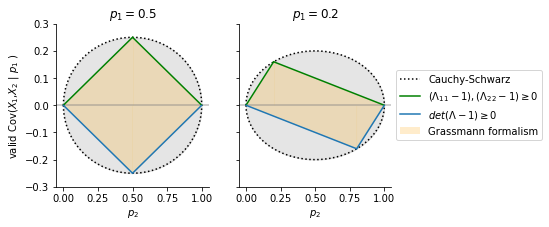

In [5]:
#### sns.set_context('notebook')



#a2 = 0.25
#a3 = 0.1

d = np.arange(0,1.001,0.001)

a1 = 0.5
limit_CS = cov_limit_CS(a1,d)
limit_upper = cov_upper_limit(a1,d)
limit_lower = cov_lower_limit(a1,d)




plt.figure(1, figsize=(6,3))

plt.subplot(121)
plt.title('$p_1=0.5$')

plt.axhline(0,  color='grey', ls="-", alpha=0.5)
plot_rectangle(d,limit_CS,limit_upper,limit_lower,
               c1= "orange",
               label_fill='$p_2 = 0.5$',
              alpha1=.2)


plt.ylim(-0.3,0.3)
plt.xlabel("$p_2$")
plt.ylabel('valid Cov($X_1$,$X_2$ | $p_1$ ) ')
sns.despine()
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

######################################################3
plt.subplot(122)
plt.title('$p_1=0.2$')
plt.axhline(0,  color='grey', ls="-", alpha=0.5)

a2 = 0.2
limit_CS = cov_limit_CS(a2,d)
limit_upper = cov_upper_limit(a2,d)
limit_lower = cov_lower_limit(a2,d)

plot_rectangle(d,limit_CS,limit_upper,limit_lower,
               c1= "orange",
               label_fill="Grassmann formalism", 
               labels=True,
              alpha1=0.2)



plt.ylim(-0.3,0.3)
plt.xlabel("$p_2$")
sns.despine()
lgd = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax=plt.gca()
ax.set_yticklabels([])

#plt.savefig("figures/cov_grassmann.png",dpi=200, bbox_extra_artists=(lgd,), bbox_inches='tight')

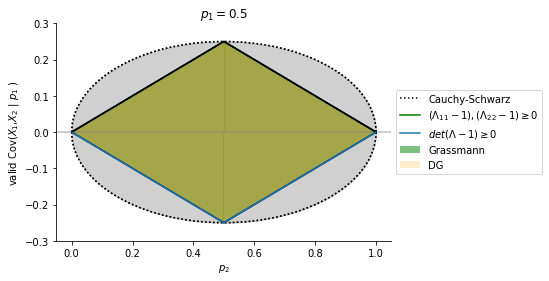

In [6]:

d = np.arange(0,1.001,0.001)

a1 = 0.5
limit_CS = cov_limit_CS(a1,d)
limit_upper = cov_upper_limit(a1,d)
limit_lower = cov_lower_limit(a1,d)



plot_rectangle(d,limit_CS,limit_upper,limit_lower,
               c1= "green",
               label_fill="Grassmann",
              alpha1=.5)


######################################################################################3
limit_upper = upper_limit_DG(d,a1)
limit_lower = lower_limit_DG(d,a1)



plt.title(f'$p_1={a1}$')

plt.axhline(0,  color='grey', ls="-", alpha=0.5)
plot_rectangle(d,limit_CS,limit_upper,limit_lower,
               c1= "orange",
               label_fill="DG",
               labels=False,
              alpha1=.2,
              c_upper="black",
              c_lower='black')


plt.ylim(-0.3,0.3)
plt.xlabel("$p_2$")
plt.ylabel('valid Cov($X_1$,$X_2$ | $p_1$ ) ')
sns.despine()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))



## marginal

$$ \begin{pmatrix} a&b \\ c&d \end{pmatrix}$$

$x_R = x_1$

$\Rightarrow p(x_R)=a^{x_r} \cdot (1-a)^{1-x_R}$